# Na początek

### Importy

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import joblib
from math import radians, sin, cos, sqrt, atan2

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBRegressor


### Ścieżki

In [2]:
# === Ścieżki
TRAIN_DATA_PATH = "../data/train_data.csv"
VAL_DATA_PATH = "../data/val_data.csv"
# TEST_DATA_PATH = "../data/test_data.csv"

MODEL_PATH = "final_models/price_classifier.pkl"
KMEANS_PATH = "final_models/kmeans_location_cluster.pkl"
ATTRIBUTES_PATH = "utils/attributes.txt"

### Pomocnicza klasa

In [3]:
# === Pomocnicza klasa
class PassthroughTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X): return X

### Analiza rozkładu zbioru treningowego

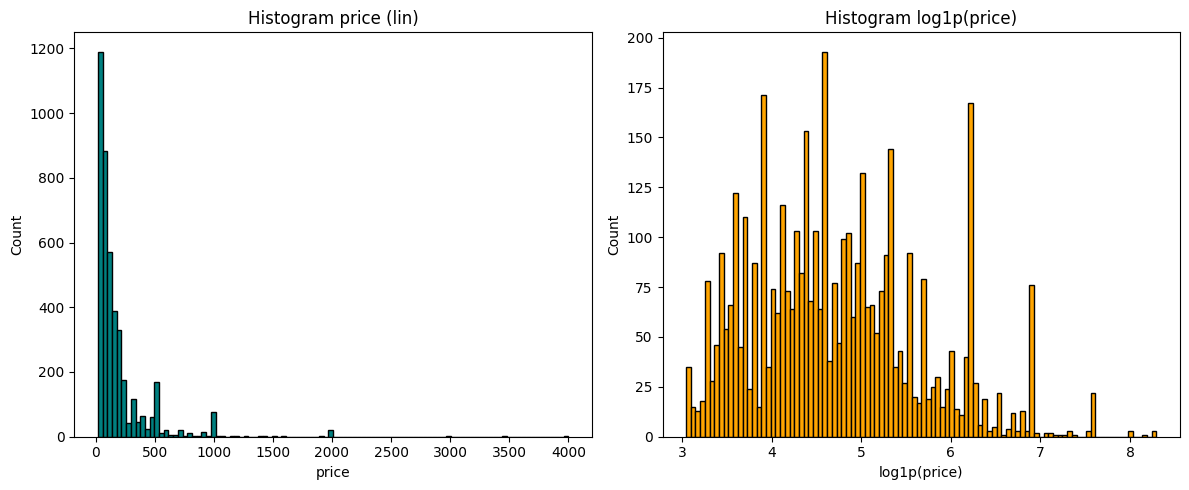

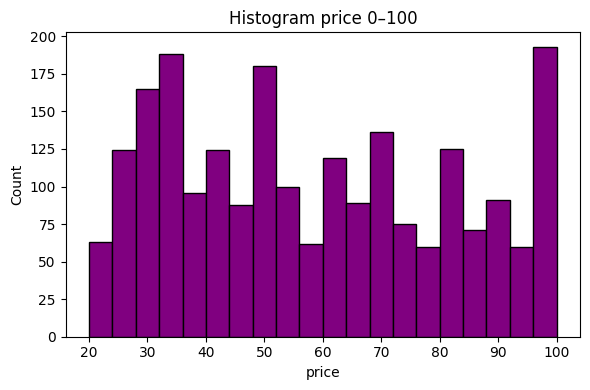

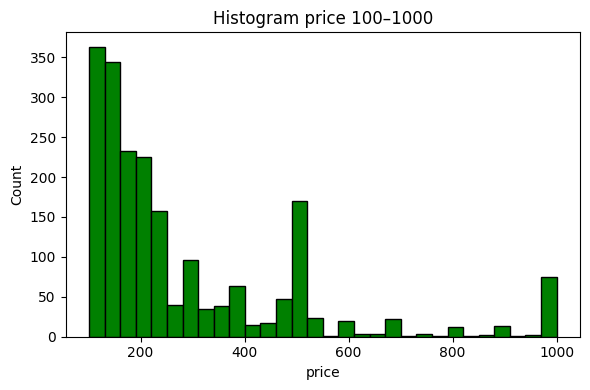

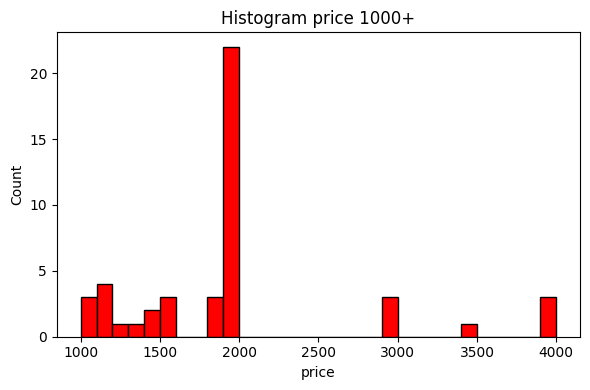

Price > 10: 100.00% obserwacji
Price > 25: 96.87% obserwacji
Price > 50: 76.20% obserwacji
Price > 100: 48.41% obserwacji
Price > 200: 22.82% obserwacji
Price > 300: 14.67% obserwacji
Price > 400: 11.19% obserwacji
Price > 500: 6.73% obserwacji
Price > 1000: 1.07% obserwacji
Price > 2000: 0.16% obserwacji
Price > 5000: 0.00% obserwacji


In [4]:
df_train = pd.read_csv(TRAIN_DATA_PATH, delimiter=';')
df = df_train.drop(columns=["id"])

#Histogram cen w skali liniowej i logarytmicznej
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['price'], bins=100, color='teal', edgecolor='black')
plt.title('Histogram price (lin)')
plt.xlabel('price')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(np.log1p(df['price']), bins=100, color='orange', edgecolor='black')
plt.title('Histogram log1p(price)')
plt.xlabel('log1p(price)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Histogram tylko dla cen 0–100
plt.figure(figsize=(6, 4))
subset_0_100 = df[df['price'] <= 100]
plt.hist(subset_0_100['price'], bins=20, color='purple', edgecolor='black')
plt.title('Histogram price 0–100')
plt.xlabel('price')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Histogram tylko dla cen 100–1000
plt.figure(figsize=(6, 4))
subset_100_1000 = df[(df['price'] > 100) & (df['price'] <= 1000)]
plt.hist(subset_100_1000['price'], bins=30, color='green', edgecolor='black')
plt.title('Histogram price 100–1000')
plt.xlabel('price')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Histogram tylko dla cen 1000+
plt.figure(figsize=(6, 4))
subset_100_1000 = df[(df['price'] > 1000)& (df['price'] <= 100000)]
plt.hist(subset_100_1000['price'], bins=30, color='red', edgecolor='black')
plt.title('Histogram price 1000+')
plt.xlabel('price')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Proporcja ofert powyżej różnych progów
for threshold in [10, 25, 50, 100, 200, 300, 400, 500, 1000, 2000, 5000]:
    pct = (df['price'] > threshold).mean() * 100
    print(f"Price > {threshold}: {pct:.2f}% obserwacji")

# Klasyfikator

In [ ]:
os.makedirs("final_models", exist_ok=True)

df_train = pd.read_csv(TRAIN_DATA_PATH, delimiter=';')
df_val = pd.read_csv(VAL_DATA_PATH, delimiter=';')

# === Binning cen
bins = [0, 100, 300, 1000, np.inf]
labels = ["bin_0_100", "bin_100_300", "bin_300_1000", "bin_1000_up"]
df_train["price_bin"] = pd.cut(df_train["price"], bins=bins, labels=labels)
df_val["price_bin"] = pd.cut(df_val["price"], bins=bins, labels=labels)

# === X, y
X_train = df_train.drop(columns=["id", "price", "price_bin"])
y_train = df_train["price_bin"]

X_val = df_val.drop(columns=["id", "price", "price_bin"])
y_val = df_val["price_bin"]

# === Zapis listy wymaganych cech
with open(ATTRIBUTES_PATH, "w") as f:
    for col in X_train.columns:
        f.write(f"{col}\n")

# === Oversampling tylko na train
print("Rozkład klas przed SMOTE:")
print(y_train.value_counts(normalize=True))

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Rozkład klas po SMOTE:")
print(pd.Series(y_train_res).value_counts(normalize=True))

# === Pipeline
binary_cols = [col for col in X_train.select_dtypes(include="number").columns if X_train[col].nunique() <= 2]
numeric_cols = [col for col in X_train.select_dtypes(include="number").columns if col not in binary_cols]

numeric_pipeline = Pipeline([
    ("selector", PassthroughTransformer()),
    ("scaler", StandardScaler())
])
binary_pipeline = Pipeline([
    ("selector", PassthroughTransformer())
])
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("bin", binary_pipeline, binary_cols)
])

classifier_pipeline = Pipeline([
    ("pre", preprocessor),
    ("clf", HistGradientBoostingClassifier(random_state=42, class_weight="balanced"))
])

# === Trening
classifier_pipeline.fit(X_train_res, y_train_res)

# === Ewaluacja
y_pred = classifier_pipeline.predict(X_val)
print("=== Classification Report (test set) ===")
print(classification_report(y_val, y_pred))
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")

# === Macierz pomyłek
cm = confusion_matrix(y_val, y_pred, labels=labels)
disp = sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.savefig("../results/img/confusion_matrix.png")
plt.close()

# === Zapis modelu
joblib.dump(classifier_pipeline, MODEL_PATH)
print(f"Zapisano model klasyfikatora do {MODEL_PATH}")


Rozkład klas przed SMOTE:
price_bin
bin_0_100       0.515880
bin_100_300     0.337459
bin_300_1000    0.135918
bin_1000_up     0.010743
Name: proportion, dtype: float64
Rozkład klas po SMOTE:
price_bin
bin_0_100       0.25
bin_100_300     0.25
bin_300_1000    0.25
bin_1000_up     0.25
Name: proportion, dtype: float64


/home/adrian/sem6/ium/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


=== Classification Report (test set) ===
              precision    recall  f1-score   support

   bin_0_100       0.82      0.83      0.82       406
 bin_1000_up       0.20      0.11      0.14         9
 bin_100_300       0.67      0.69      0.68       322
bin_300_1000       0.59      0.57      0.58       120

    accuracy                           0.73       857
   macro avg       0.57      0.55      0.56       857
weighted avg       0.73      0.73      0.73       857

Accuracy: 0.7293
Zapisano model klasyfikatora do final_models/price_classifier.pkl


## Demonstracja działania

Zapisano wyniki do ../results/bin_predictions.csv
            id  price     price_bin predicted_bin  correct
0  6,79339E+17   54.0     bin_0_100   bin_100_300    False
1     52719337   68.0     bin_0_100     bin_0_100     True
2     48181789  525.0  bin_300_1000  bin_300_1000     True
3     44402717   99.0     bin_0_100     bin_0_100     True
4     29197896   78.0     bin_0_100     bin_0_100     True

Udział dobrze i źle przewidzianych przedziałów:
correct
True     0.729288
False    0.270712
Name: proportion, dtype: float64

Skuteczność klasyfikatora: 72.93%


/home/adrian/sem6/ium/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


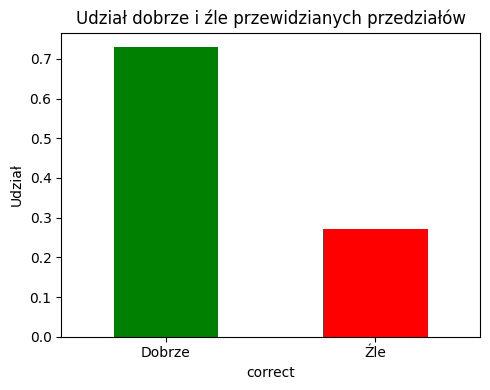

In [6]:
OUTPUT_PATH = "../results/bin_predictions.csv"

# === Przygotowanie danych
X = df_val.drop(columns=["price", "id"])
if "price_bin" in X.columns:
    X = X.drop(columns=["price_bin"])
y = df_val["price_bin"].copy()

# === Wczytaj model
model = joblib.load(MODEL_PATH)

# === Predykcja
predicted_bins = model.predict(X)

# === Porównanie
output_df = df_val[["id", "price", "price_bin"]].copy()
output_df["predicted_bin"] = predicted_bins
output_df["correct"] = y == output_df["predicted_bin"]

# === Eksport
output_df.to_csv(OUTPUT_PATH, index=False)
print(f"Zapisano wyniki do {OUTPUT_PATH}")

# Pokaż pierwsze wiersze
print(output_df.head())

# Policz udział dobrze i źle przewidzianych
correct_counts = output_df['correct'].value_counts(normalize=True)
print("\nUdział dobrze i źle przewidzianych przedziałów:")
print(correct_counts)

# Skuteczność w procentach
accuracy_pct = 100 * correct_counts.get(True, 0)
print(f"\nSkuteczność klasyfikatora: {accuracy_pct:.2f}%")

# Wykres
plt.figure(figsize=(5, 4))
correct_counts.plot(kind='bar', color=['green', 'red'])
plt.xticks([0, 1], ['Dobrze', 'Źle'], rotation=0)
plt.ylabel('Udział')
plt.title('Udział dobrze i źle przewidzianych przedziałów')
plt.tight_layout()
plt.savefig('../results/img/true_false_predictions.png')
plt.show()

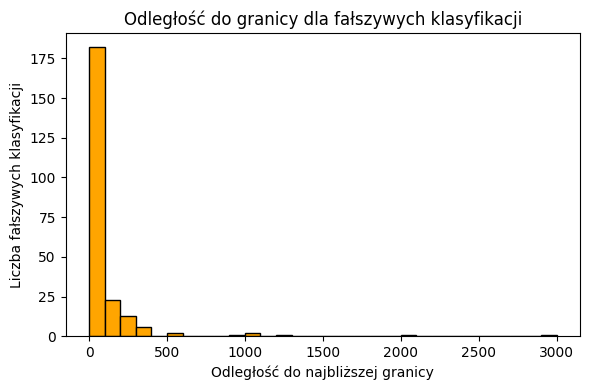

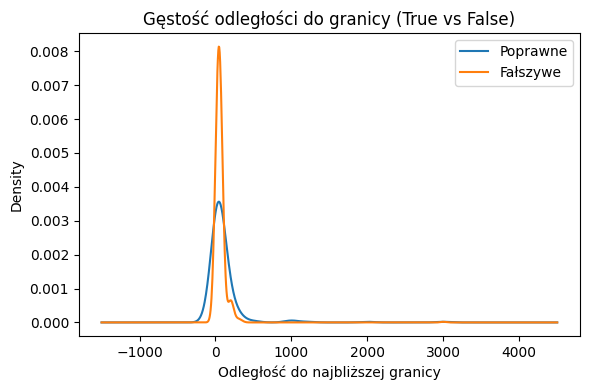

Średnia odległość do granicy (poprawne): 62.99
Średnia odległość do granicy (fałszywe): 104.40
Test Mann-Whitney U, p-value: 0.2345


In [7]:
# Sprawdź jak blisko wartości granicznych (100, 300, 1000) są ceny dla fałszywych klasyfikacji
boundaries = [100, 300, 1000]

# Dodaj kolumnę z minimalną odległością do granicy
def min_dist_to_boundary(price):
    return min(abs(price - b) for b in boundaries)

false_cases = output_df[~output_df['correct']].copy()
false_cases['dist_to_boundary'] = false_cases['price'].apply(min_dist_to_boundary)

# Histogram odległości do granicy dla fałszywych klasyfikacji
plt.figure(figsize=(6, 4))
plt.hist(false_cases['dist_to_boundary'], bins=30, color='orange', edgecolor='black')
plt.xlabel('Odległość do najbliższej granicy')
plt.ylabel('Liczba fałszywych klasyfikacji')
plt.title('Odległość do granicy dla fałszywych klasyfikacji')
plt.tight_layout()
plt.savefig('../results/img/false_distance.png')
plt.show()

# Porównanie: odległość do granicy dla przypadków poprawnych vs fałszywych
output_df['dist_to_boundary'] = output_df['price'].apply(min_dist_to_boundary)
plt.figure(figsize=(6, 4))
output_df.groupby('correct')['dist_to_boundary'].plot(kind='kde', legend=True)
plt.xlabel('Odległość do najbliższej granicy')
plt.title('Gęstość odległości do granicy (True vs False)')
plt.legend(['Poprawne', 'Fałszywe'])
plt.tight_layout()
plt.savefig('../results/img/distances_density.png')
plt.show()

# Test statystyczny: czy fałszywe klasyfikacje są bliżej granic niż poprawne?
from scipy.stats import mannwhitneyu
stat, pval = mannwhitneyu(
    output_df[output_df['correct']]['dist_to_boundary'],
    output_df[~output_df['correct']]['dist_to_boundary'],
    alternative='greater'
)
print(f"Średnia odległość do granicy (poprawne): {output_df[output_df['correct']]['dist_to_boundary'].mean():.2f}")
print(f"Średnia odległość do granicy (fałszywe): {output_df[~output_df['correct']]['dist_to_boundary'].mean():.2f}")
print(f"Test Mann-Whitney U, p-value: {pval:.4f}")

# Regresory

## Regresor 0 - 100

In [11]:
MODEL_OUTPUT_PATH = "final_models/xgb_regressor_bin_0_100.pkl"

df_train = pd.read_csv(TRAIN_DATA_PATH, delimiter=';')
df_val = pd.read_csv(VAL_DATA_PATH, delimiter=';')

# === Binning cen
bins = [0, 100, 300, 1000, np.inf]
labels = ["bin_0_100", "bin_100_300", "bin_300_1000", "bin_1000_up"]
df_train["price_bin"] = pd.cut(df_train["price"], bins=bins, labels=labels)
df_val["price_bin"] = pd.cut(df_val["price"], bins=bins, labels=labels)

df_t = df_train[df_train["price_bin"] == "bin_0_100"].copy()
df_v = df_val[df_val["price_bin"] == "bin_0_100"].copy()

df_t["target"] = np.log1p(df_t["price"])
df_v["target"] = np.log1p(df_v["price"])

# Wczytanie cech
with open(ATTRIBUTES_PATH) as f:
    feature_cols = [line.strip() for line in f]

X_train = df_t[feature_cols]
y_train = df_t["target"]

X_val = df_v[feature_cols]
y_val = df_v["target"]

binary_cols = [col for col in X_train.select_dtypes(include="number").columns if X_train[col].nunique() <= 2]
numeric_cols = [col for col in X_train.select_dtypes(include="number").columns if col not in binary_cols]

numeric_pipeline = Pipeline([("selector", PassthroughTransformer()), ("scaler", StandardScaler())])
binary_pipeline = Pipeline([("selector", PassthroughTransformer())])
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("bin", binary_pipeline, binary_cols)
])

# Model
regressor = XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1)

param_grid = {
    "reg__max_depth": [5, 10],
    "reg__learning_rate": [0.01],
    "reg__n_estimators": [300, 500],
    "reg__subsample": [0.8, 1.0],
    "reg__colsample_bytree": [0.8, 1.0]
}

pipeline = Pipeline([
    ("pre", preprocessor),
    ("reg", regressor)
])

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring="neg_root_mean_squared_error", verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

# === Ewaluacja
best_model = grid.best_estimator_
y_pred_log = best_model.predict(X_val)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_val)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("=== XGBoost Metrics on bin_0_100 ===")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")
print("Best params:", grid.best_params_)

joblib.dump(best_model, MODEL_OUTPUT_PATH)
print(f"Zapisano XGBoost regresor do {MODEL_OUTPUT_PATH}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits


/home/adrian/sem6/ium/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/adrian/sem6/ium/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/adrian/sem6/ium/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/adrian/sem6/ium/.venv/lib/python3.13/site-p

=== XGBoost Metrics on bin_0_100 ===
MAE:  13.98
RMSE: 18.12
R²:   0.3894
Best params: {'reg__colsample_bytree': 1.0, 'reg__learning_rate': 0.01, 'reg__max_depth': 5, 'reg__n_estimators': 300, 'reg__subsample': 0.8}
Zapisano XGBoost regresor do final_models/xgb_regressor_bin_0_100.pkl


Metryki dla tego regresora to:

=== XGBoost Metrics on bin_0_100 ===
| Metryka | Wartość   |
|---------|-----------|
| MAE     | 13.98     |
| RMSE    | 18.12     |
| R²      | 0.3894    |

## Regresor 100 - 300

In [13]:
MODEL_OUTPUT_PATH = "final_models/xgb_regressor_bin_100_300.pkl"

df_train = pd.read_csv(TRAIN_DATA_PATH, delimiter=';')
df_val = pd.read_csv(VAL_DATA_PATH, delimiter=';')

# === Binning cen
bins = [0, 100, 300, 1000, np.inf]
labels = ["bin_0_100", "bin_100_300", "bin_300_1000", "bin_1000_up"]
df_train["price_bin"] = pd.cut(df_train["price"], bins=bins, labels=labels)
df_val["price_bin"] = pd.cut(df_val["price"], bins=bins, labels=labels)

df_t = df_train[df_train["price_bin"] == "bin_100_300"].copy()
df_v = df_val[df_val["price_bin"] == "bin_100_300"].copy()

df_t["target"] = np.log1p(df_t["price"])
df_v["target"] = np.log1p(df_v["price"])

# === Wczytanie cech
with open(ATTRIBUTES_PATH) as f:
    feature_cols = [line.strip() for line in f]

X_train = df_t[feature_cols]
y_train = df_t["target"]

X_val = df_v[feature_cols]
y_val = df_v["target"]

# === Preprocessing
binary_cols = [col for col in X_train.select_dtypes(include="number").columns if X_train[col].nunique() <= 2]
numeric_cols = [col for col in X_train.select_dtypes(include="number").columns if col not in binary_cols]

numeric_pipeline = Pipeline([
    ("selector", PassthroughTransformer()),
    ("scaler", StandardScaler())
])
binary_pipeline = Pipeline([
    ("selector", PassthroughTransformer())
])
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("bin", binary_pipeline, binary_cols)
])

# === Model i grid
xgb = XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1)

pipeline = Pipeline([
    ("pre", preprocessor),
    ("reg", xgb)
])

param_grid = {
    "reg__max_depth": [5, 10, 15],
    "reg__n_estimators": [200, 300],
    "reg__learning_rate": [0.01, 0.05],
    "reg__subsample": [0.8, 1.0],
    "reg__colsample_bytree": [0.8, 1.0]
}

grid = GridSearchCV(
    pipeline, param_grid, cv=3,
    scoring="neg_root_mean_squared_error",
    verbose=1, n_jobs=-1
)
grid.fit(X_train, y_train)

# === Ewaluacja
best_model = grid.best_estimator_
y_pred_log = best_model.predict(X_val)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_val)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("=== XGBoost Metrics on bin_100_300 ===")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")
print("Best params:", grid.best_params_)

# === Zapis
joblib.dump(best_model, MODEL_OUTPUT_PATH)
print(f"Zapisano XGBoost regresor do {MODEL_OUTPUT_PATH}")


Fitting 3 folds for each of 48 candidates, totalling 144 fits


/home/adrian/sem6/ium/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/adrian/sem6/ium/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/adrian/sem6/ium/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/adrian/sem6/ium/.venv/lib/python3.13/site-p

=== XGBoost Metrics on bin_100_300 ===
MAE:  41.39
RMSE: 53.10
R²:   0.1437
Best params: {'reg__colsample_bytree': 0.8, 'reg__learning_rate': 0.01, 'reg__max_depth': 15, 'reg__n_estimators': 300, 'reg__subsample': 0.8}
Zapisano XGBoost regresor do final_models/xgb_regressor_bin_100_300.pkl


Regresor działa następująco:


=== XGBoost Metrics on bin_100_300 ===
| Metryka | Wartość   |
|---------|-----------|
| MAE     | 41.39     |
| RMSE    | 53.10     |
| R²      | 0.1437    |

## Regresor 300 - 1000

In [15]:
MODEL_OUTPUT_PATH = "final_models/xgb_regressor_bin_300_1000.pkl"

df_train = pd.read_csv(TRAIN_DATA_PATH, delimiter=';')
df_val = pd.read_csv(VAL_DATA_PATH, delimiter=';')

# === Binning cen
bins = [0, 100, 300, 1000, np.inf]
labels = ["bin_0_100", "bin_100_300", "bin_300_1000", "bin_1000_up"]
df_train["price_bin"] = pd.cut(df_train["price"], bins=bins, labels=labels)
df_val["price_bin"] = pd.cut(df_val["price"], bins=bins, labels=labels)

df_t = df_train[df_train["price_bin"] == "bin_300_1000"].copy()
df_v = df_val[df_val["price_bin"] == "bin_300_1000"].copy()

df_t["target"] = np.log1p(df_t["price"])
df_v["target"] = np.log1p(df_v["price"])

# === Cechy
with open(ATTRIBUTES_PATH) as f:
    feature_cols = [line.strip() for line in f]

X_train = df_t[feature_cols]
y_train = df_t["target"]

X_val = df_v[feature_cols]
y_val = df_v["target"]

binary_cols = [col for col in X_train.select_dtypes(include="number").columns if X_train[col].nunique() <= 2]
numeric_cols = [col for col in X_train.select_dtypes(include="number").columns if col not in binary_cols]

numeric_pipeline = Pipeline([
    ("selector", PassthroughTransformer()),
    ("scaler", StandardScaler())
])
binary_pipeline = Pipeline([
    ("selector", PassthroughTransformer())
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("bin", binary_pipeline, binary_cols)
])

regressor = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

param_grid = {
    "reg__max_depth": [10, 15, 20],
    "reg__learning_rate": [0.005, 0.01, 0.02],
    "reg__n_estimators": [300, 500, 800],
    "reg__subsample": [0.7, 0.8, 1.0],
    "reg__colsample_bytree": [0.7, 0.9, 1.0]
}

pipeline = Pipeline([
    ("pre", preprocessor),
    ("reg", regressor)
])

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring="neg_root_mean_squared_error", verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

# === Ewaluacja
best_model = grid.best_estimator_
y_pred_log = best_model.predict(X_val)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_val)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("=== XGBoost Metrics on bin_300_1000 ===")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")
print("Best params:", grid.best_params_)

joblib.dump(best_model, MODEL_OUTPUT_PATH)
print(f"Zapisano XGBoost regresor do {MODEL_OUTPUT_PATH}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits


/home/adrian/sem6/ium/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/adrian/sem6/ium/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/adrian/sem6/ium/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/adrian/sem6/ium/.venv/lib/python3.13/site-p

=== XGBoost Metrics on bin_300_1000 ===
MAE:  111.25
RMSE: 168.03
R²:   0.1805
Best params: {'reg__colsample_bytree': 0.9, 'reg__learning_rate': 0.01, 'reg__max_depth': 10, 'reg__n_estimators': 500, 'reg__subsample': 0.7}
Zapisano XGBoost regresor do final_models/xgb_regressor_bin_300_1000.pkl


Regresor działa następująco:

=== XGBoost Metrics on bin_300_1000 ===
| Metryka | Wartość      |
|---------|--------------|
| MAE     | 111.25       |
| RMSE    | 168.03       |
| R²      | 0.1805       |

## Regresor 1000+

In [18]:
MODEL_OUTPUT_PATH = "final_models/xgb_regressor_bin_1000_up.pkl"

df_train = pd.read_csv(TRAIN_DATA_PATH, delimiter=';')
df_val = pd.read_csv(VAL_DATA_PATH, delimiter=';')

# === Binning cen
bins = [0, 100, 300, 1000, np.inf]
labels = ["bin_0_100", "bin_100_300", "bin_300_1000", "bin_1000_up"]
df_train["price_bin"] = pd.cut(df_train["price"], bins=bins, labels=labels)
df_val["price_bin"] = pd.cut(df_val["price"], bins=bins, labels=labels)

df_t = df_train[df_train["price_bin"] == "bin_1000_up"].copy()
df_v = df_val[df_val["price_bin"] == "bin_1000_up"].copy()

df_t["target"] = np.log1p(df_t["price"])
df_v["target"] = np.log1p(df_v["price"])

# === Wczytanie cech
with open(ATTRIBUTES_PATH) as f:
    feature_cols = [line.strip() for line in f]

X_train = df_t[feature_cols]
y_train = df_t["target"]

X_val = df_v[feature_cols]
y_val = df_v["target"]

# === Przetwarzanie kolumn
binary_cols = [col for col in X_train.select_dtypes(include="number").columns if X_train[col].nunique() <= 2]
numeric_cols = [col for col in X_train.select_dtypes(include="number").columns if col not in binary_cols]

numeric_pipeline = Pipeline([
    ("selector", PassthroughTransformer()),
    ("scaler", StandardScaler())
])
binary_pipeline = Pipeline([
    ("selector", PassthroughTransformer())
])
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("bin", binary_pipeline, binary_cols)
])

# === Model i siatka parametrów
regressor = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

param_grid = {
    "reg__learning_rate": [0.01, 0.05],
    "reg__n_estimators": [300, 500, 1000],
    "reg__max_depth": [10, 15, 20],
    "reg__subsample": [0.8, 1.0],
    "reg__colsample_bytree": [0.8, 1.0]
}

pipeline = Pipeline([
    ("pre", preprocessor),
    ("reg", regressor)
])

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring="neg_root_mean_squared_error",
    verbose=1,
    n_jobs=-1
)
grid.fit(X_train, y_train)

# === Ewaluacja
best_model = grid.best_estimator_
y_pred_log = best_model.predict(X_val)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_val)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("=== XGBoost Metrics on bin_1000_up ===")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")
print("Best params:", grid.best_params_)

# === Zapis modelu
joblib.dump(best_model, MODEL_OUTPUT_PATH)
print(f"Zapisano XGBoost regresor do {MODEL_OUTPUT_PATH}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/home/adrian/sem6/ium/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/adrian/sem6/ium/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/adrian/sem6/ium/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/adrian/sem6/ium/.venv/lib/python3.13/site-p

=== XGBoost Metrics on bin_1000_up ===
MAE:  834.08
RMSE: 1150.78
R²:   -0.5743
Best params: {'reg__colsample_bytree': 0.8, 'reg__learning_rate': 0.01, 'reg__max_depth': 15, 'reg__n_estimators': 300, 'reg__subsample': 0.8}
Zapisano XGBoost regresor do final_models/xgb_regressor_bin_1000_up.pkl


Ten regresor działa kiepsko:

=== XGBoost Metrics on bin_1000_up ===
| Metryka | Wartość      |
|---------|--------------|
| MAE     | 834.08       |
| RMSE    | 1150.78      |
| R²      | -0.5743      |

Dobrze, że pokrywa tylko 2% przypadków

# Kompleksowa ewaluacja (cały zbiór walidacyjny)
Przygotowano skrypt - logikę przewidywania ceny. Podobna logika zostanie zaimplementowana w mikroserwisie.
Korzystamy z klasyfikatora i dobieramy regresor.
Jeżeli regresor zwróci wartość poza zakresem swojego przedziału, ucinamy ją do najbliższej granicy. (Wcześniej zauważono, że niektóre ceny wykraczają lekko poza zakres)

In [ ]:
CLASSIFIER_PATH = "final_models/price_classifier.pkl"
REGRESSOR_PATHS = {
    "bin_0_100": "final_models/xgb_regressor_bin_0_100.pkl",
    "bin_100_300": "final_models/xgb_regressor_bin_100_300.pkl",
    "bin_300_1000": "final_models/xgb_regressor_bin_300_1000.pkl",
    "bin_1000_up": "final_models/xgb_regressor_bin_1000_up.pkl"
}

df = pd.read_csv(VAL_DATA_PATH, delimiter=';')

df = df[(df["price"] >= df["price"].quantile(0.01)) & (df["price"] <= df["price"].quantile(0.99))].copy()

with open(ATTRIBUTES_PATH) as f:
    feature_cols = [line.strip() for line in f]

X = df[feature_cols]
y_true = df["price"]
ids = df["id"]

classifier = joblib.load(CLASSIFIER_PATH)
regressors = {k: joblib.load(v) for k, v in REGRESSOR_PATHS.items()}

predicted_bins = classifier.predict(X)
predicted_prices = []

# Zakresy dla każdego binu
bin_ranges = {
    "bin_0_100": (0, 100),
    "bin_100_300": (100, 300),
    "bin_300_1000": (300, 1000),
    "bin_1000_up": (1000, np.inf)
}

for i in range(len(X)):
    bin_label = predicted_bins[i]
    regressor = regressors[bin_label]
    # Sprawdź, czy regresor był trenowany na log(price) — dotyczy binów powyżej 100
    price_pred = np.expm1(regressor.predict(X.iloc[[i]])[0])  # odwrotność log1p

    # Przycięcie do zakresu
    lower, upper = bin_ranges[bin_label]
    if price_pred < lower:
        price_pred = lower
    elif price_pred > upper:
        price_pred = upper
    # elif price_pred < 50:
    #     price_pred = 50
    predicted_prices.append(price_pred)

# === Metryki
mae = mean_absolute_error(y_true, predicted_prices)
rmse = np.sqrt(mean_squared_error(y_true, predicted_prices))
r2 = r2_score(y_true, predicted_prices)

print("=== Global Metrics ===")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

# === Zapis wyników
# === Zapis wyników z dokładnością i błędem
bin_edges = [0, 100, 300, 1000, np.inf]
bin_labels = ["bin_0_100", "bin_100_300", "bin_300_1000", "bin_1000_up"]
true_bins = pd.cut(y_true, bins=bin_edges, labels=bin_labels)

correct = predicted_bins == true_bins.values
errors = np.abs(y_true - predicted_prices)

results = pd.DataFrame({
    "id": ids,
    "price": y_true,
    "predicted_bin": predicted_bins,
    "correct": correct,
    "predicted_price": predicted_prices,
    "error": errors
})

results.to_csv("evaluation_full_pipeline.csv", index=False)
print("Zapisano do evaluation_full_pipeline.csv")

=== Global Metrics ===
MAE:  83.97
RMSE: 183.14
R²:   -0.0697
Zapisano do evaluation_full_pipeline.csv


In [24]:
# Wczytaj plik z wynikami
results = pd.read_csv("evaluation_full_pipeline.csv")

# Definicja zakresów dla każdego binu
bin_ranges = {
    "bin_0_100": (0, 100),
    "bin_100_300": (100, 300),
    "bin_300_1000": (300, 1000),
    "bin_1000_up": (1000, float('inf'))
}

# Funkcja sprawdzająca, czy cena wykracza poza zakres bina
def is_out_of_bin(row):
    lower, upper = bin_ranges[row['predicted_bin']]
    if row['predicted_bin'] == 'bin_1000_up':
        return row['predicted_price'] < lower
    return not (lower <= row['predicted_price'] <= upper)

# Dodaj kolumnę informującą o wyjściu poza bin
results['out_of_bin'] = results.apply(is_out_of_bin, axis=1)

# Wypisz przypadki dla każdego binu, gdzie cena wykracza poza bin
for bin_label in bin_ranges.keys():
    out_bin_cases = results[(results['predicted_bin'] == bin_label) & (results['out_of_bin'])]
    print(f"\nPrzypadki wykraczające poza bin: {bin_label} (liczba: {len(out_bin_cases)})")
    if not out_bin_cases.empty:
        display_cols = ['id', 'price', 'predicted_bin', 'predicted_price', 'error']
        print(out_bin_cases[display_cols])


Przypadki wykraczające poza bin: bin_0_100 (liczba: 0)

Przypadki wykraczające poza bin: bin_100_300 (liczba: 0)

Przypadki wykraczające poza bin: bin_300_1000 (liczba: 0)

Przypadki wykraczające poza bin: bin_1000_up (liczba: 0)


Skuteczność klasyfikacji binów (predicted_bin):
predicted_bin
bin_0_100       0.822055
bin_1000_up     0.000000
bin_100_300     0.680000
bin_300_1000    0.607143
Name: correct, dtype: float64

Udział poprawnych/niepoprawnych klasyfikacji:
correct
False    0.265476
True     0.734524
Name: price, dtype: float64


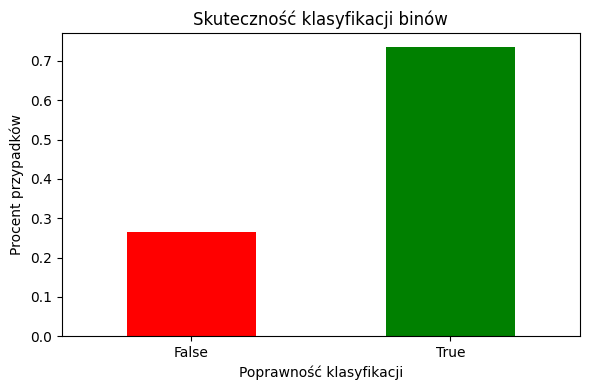

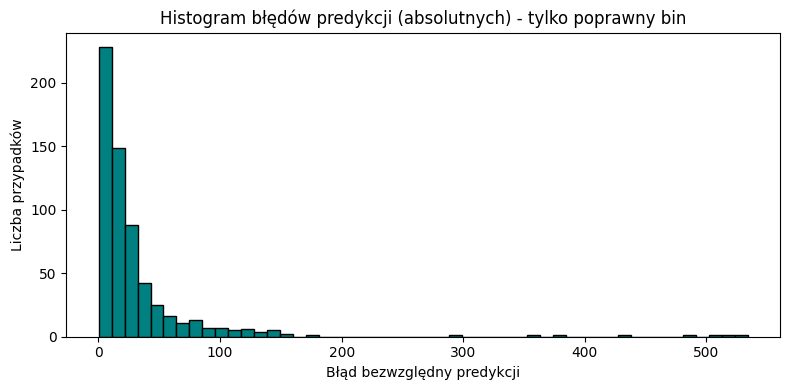

<Figure size 800x400 with 0 Axes>

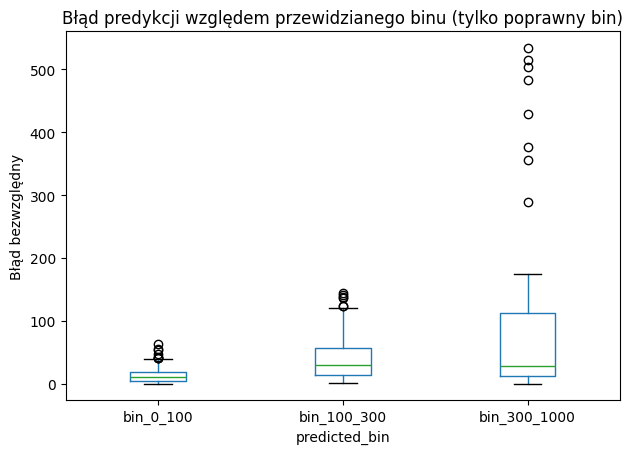

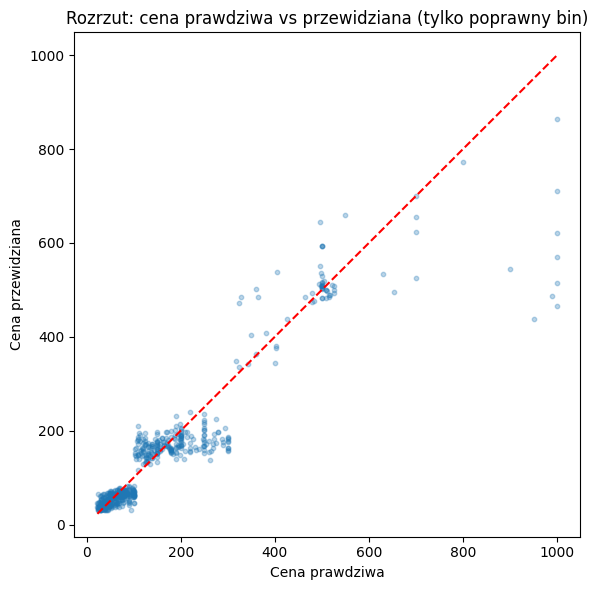

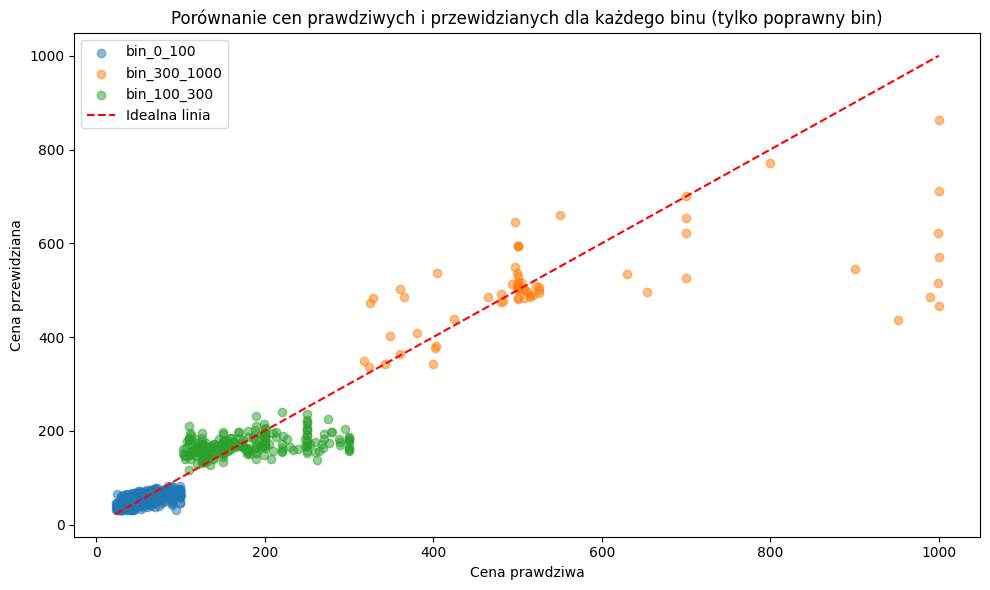

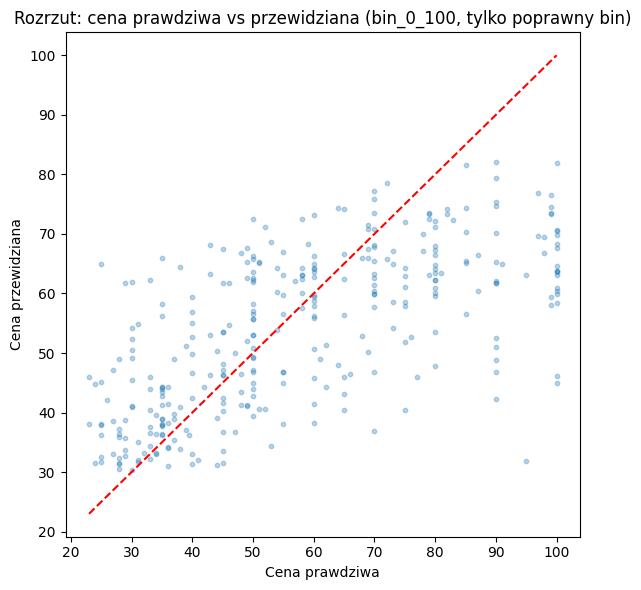

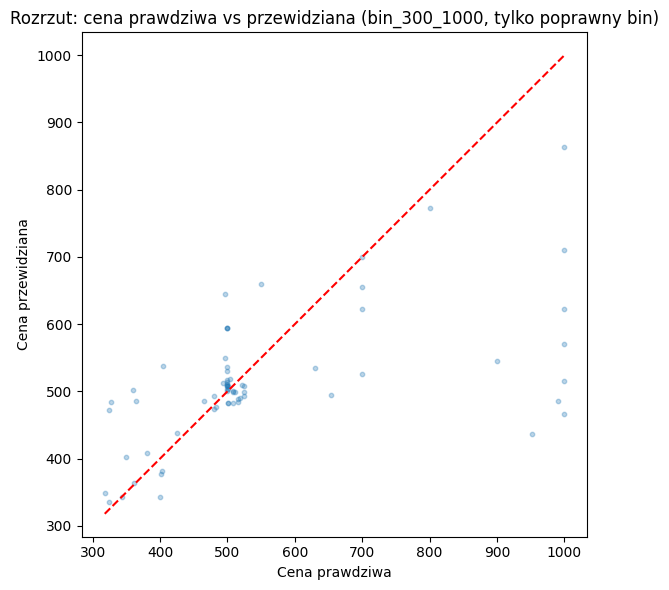

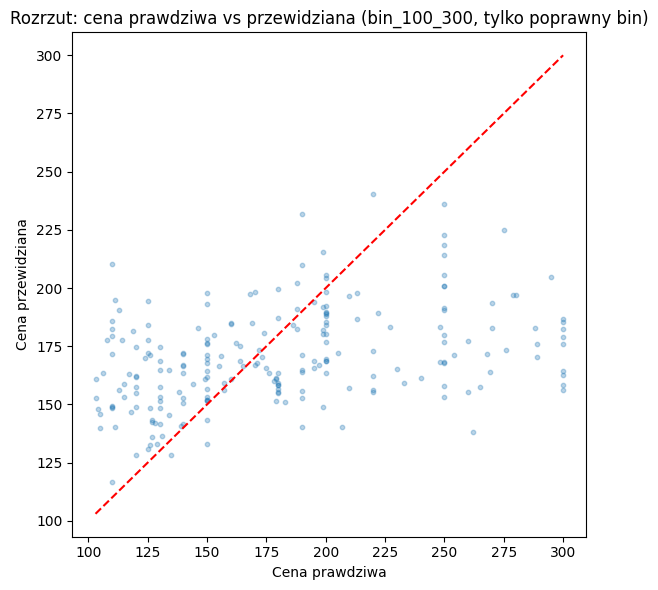

In [34]:
results = pd.read_csv("evaluation_full_pipeline.csv")

# Skuteczność klasyfikacji binów
bin_acc = results.groupby("predicted_bin")["correct"].mean()
print("Skuteczność klasyfikacji binów (predicted_bin):")
print(bin_acc)

# Skuteczność klasyfikacji względem prawdziwego binu
true_bin_acc = results.groupby("correct")["price"].count() / len(results)
print("\nUdział poprawnych/niepoprawnych klasyfikacji:")
print(true_bin_acc)
plt.figure(figsize=(6, 4))
true_bin_acc.plot(kind="bar", color=["red", "green"])
plt.xlabel("Poprawność klasyfikacji")
plt.ylabel("Procent przypadków")
plt.title("Skuteczność klasyfikacji binów")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Filtruj tylko przypadki z poprawnie przewidzianym binem
correct_results = results[results["correct"]]

# Histogram błędów predykcji (absolute error) dla poprawnych binów
plt.figure(figsize=(8, 4))
plt.hist(correct_results["error"], bins=50, color="teal", edgecolor="black")
plt.xlabel("Błąd bezwzględny predykcji")
plt.ylabel("Liczba przypadków")
plt.title("Histogram błędów predykcji (absolutnych) - tylko poprawny bin")
plt.tight_layout()
plt.show()

# Boxplot błędów predykcji dla każdego binu (tylko poprawny bin)
plt.figure(figsize=(8, 4))
correct_results.boxplot(column="error", by="predicted_bin", grid=False)
plt.ylabel("Błąd bezwzględny")
plt.title("Błąd predykcji względem przewidzianego binu (tylko poprawny bin)")
plt.suptitle("")
plt.tight_layout()
plt.show()

# Wykres rozrzutu: cena prawdziwa vs przewidziana (tylko poprawny bin)
plt.figure(figsize=(6, 6))
plt.scatter(correct_results["price"], correct_results["predicted_price"], alpha=0.3, s=10)
plt.plot([correct_results["price"].min(), correct_results["price"].max()],
         [correct_results["price"].min(), correct_results["price"].max()], 'r--')
plt.xlabel("Cena prawdziwa")
plt.ylabel("Cena przewidziana")
plt.title("Rozrzut: cena prawdziwa vs przewidziana (tylko poprawny bin)")
plt.tight_layout()
plt.show()

# Wykresy skuteczności regresorów (tylko poprawny bin)
plt.figure(figsize=(10, 6))
for bin_label in correct_results["predicted_bin"].unique():
    subset = correct_results[correct_results["predicted_bin"] == bin_label]
    plt.scatter(subset["price"], subset["predicted_price"], label=bin_label, alpha=0.5)
plt.plot([correct_results["price"].min(), correct_results["price"].max()],
         [correct_results["price"].min(), correct_results["price"].max()], 'r--', label="Idealna linia")
plt.xlabel("Cena prawdziwa")
plt.ylabel("Cena przewidziana")
plt.title("Porównanie cen prawdziwych i przewidzianych dla każdego binu (tylko poprawny bin)")
plt.legend()
plt.tight_layout()
plt.show()

# Osobne wykresy dla każdego binu (tylko poprawny bin)
for bin_label in correct_results["predicted_bin"].unique():
    subset = correct_results[correct_results["predicted_bin"] == bin_label]
    plt.figure(figsize=(6, 6))
    plt.scatter(subset["price"], subset["predicted_price"], alpha=0.3, s=10)
    plt.plot([subset["price"].min(), subset["price"].max()],
             [subset["price"].min(), subset["price"].max()], 'r--')
    plt.xlabel("Cena prawdziwa")
    plt.ylabel("Cena przewidziana")
    plt.title(f"Rozrzut: cena prawdziwa vs przewidziana ({bin_label}, tylko poprawny bin)")
    plt.tight_layout()
    plt.show()


## Metryki dla bazowego modelu

### Mediana

In [41]:
print(df_train['price'].median())

100.0


In [42]:
median_l = pd.DataFrame([100 for _ in range(len(y_true))])
mae = mean_absolute_error(y_true, median_l)
rmse = np.sqrt(mean_squared_error(y_true, median_l))
r2 = r2_score(y_true, median_l)
print("=== Global Metrics (for basic model) ===")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

=== Global Metrics (for basic model) ===
MAE:  112.66
RMSE: 192.49
R²:   -0.1817


### Średnia

In [43]:
print(df_train['price'].mean())

186.6598552078468


In [44]:
mean_l = pd.DataFrame([186 for _ in range(len(y_true))])
mae = mean_absolute_error(y_true, mean_l)
rmse = np.sqrt(mean_squared_error(y_true, mean_l))
r2 = r2_score(y_true, mean_l)
print("=== Global Metrics (for basic model) ===")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

=== Global Metrics (for basic model) ===
MAE:  128.00
RMSE: 177.39
R²:   -0.0035
